Roger Sayle contributed an implementation of sphere-exclusion picking to the RDKit as part of the 2019.09 release and I recently realized that I'd never blogged about that code or how to use it to do compound clustering. So here's a short(ish) one.

The RDKit has had an implementation of the MaxMin algorithm for picking diverse compounds for quite a while (Roger made this a lot faster back in 2017). The input to the MaxMin picker is the number of diverse compounds you want. The new algorithm is different: you provide the minimum distance allowed between the compounds picked and it returns a set of compounds satisfying that constraint. 

Both of these methods for picking diverse compounds can then be converted into clustering algorithms by defining those picked points to be cluster centroids and then assigning non-picked compounds to the nearest centroid. We'll do that here for the sphere-exclusion algorithm.

Further reading:
- for more about the sphere-exclusion picker and/or learn how it works: [here's Roger's UGM presentation](https://github.com/rdkit/UGM_2019/raw/master/Presentations/Sayle_Clustering.pdf)
- Roger's UGM presentation describing his fast implementation of the MaxMin picker is [here](https://github.com/rdkit/UGM_2017/raw/master/Presentations/Sayle_RDKitDiversity_Berlin17.pdf)
- Tim Dudgeon's [guest post on this blog](https://rdkit.blogspot.com/2017/11/revisting-maxminpicker.html) provides a nice overview of the new MaxMin picker.

In [1]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor, rdMolDescriptors
import time
rdDepictor.SetPreferCoordGen(True)
import rdkit
%pylab inline
print(rdkit.__version__)

Populating the interactive namespace from numpy and matplotlib
2020.09.1


# First dataset

The dataset we'll start with is the "new Lessel and Briem" set that I put together as part of [this blog post](http://rdkit.blogspot.com/2019/10/a-new-lessel-and-briem-like-dataset.html)

In [2]:
ms = [x for x in Chem.SmilesMolSupplier('../data/BLSets_selected_actives.txt')]
len(ms)

6359

We'll use MFP2 fingerprints:

In [3]:
from rdkit.Chem import rdMolDescriptors
fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m,2,2048) for m in ms]

The new sphere-exclusion code is available using the `LeaderPicker`:

In [4]:
from rdkit.SimDivFilters import rdSimDivPickers
lp = rdSimDivPickers.LeaderPicker()

And we pick compounds by giving the picker the fingerprints and a minimum distance between cluster centroids. Here we're using a distance threshold of 0.65, which is the random-similarity threshold [I found for MFP2 fingeprints](http://rdkit.blogspot.com/2013/10/fingerprint-thresholds.html).

In [5]:
thresh = 0.65 # <- minimum distance between cluster centroids
picks = lp.LazyBitVectorPick(fps,len(fps),thresh)
print(len(picks))

535


For reference, here's how long that takes to run:

In [6]:
%timeit lp.LazyBitVectorPick(fps,len(fps),thresh)

41.9 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's look at some of those picked compounds:

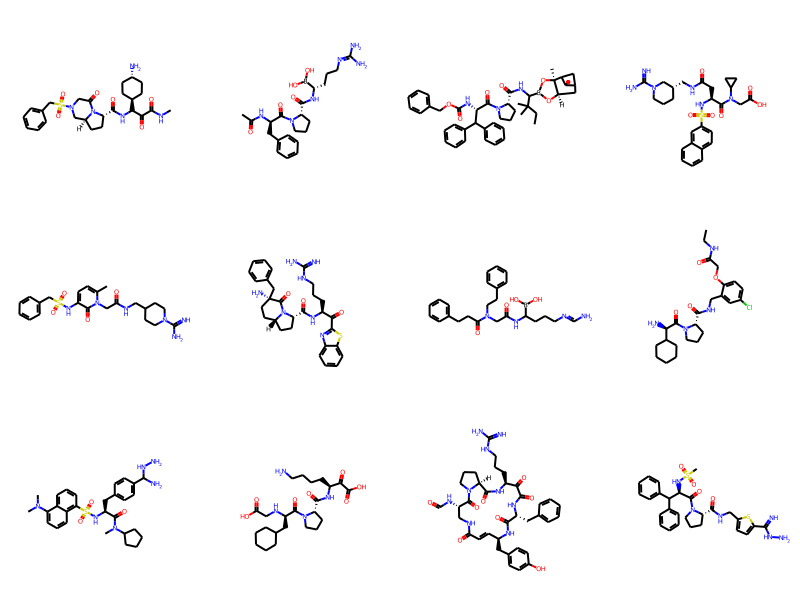

In [7]:
Draw.MolsToGridImage([ms[x] for x in picks[:12]],molsPerRow=4)

Just to get a feeling for what's going on, calculate the similarities between the compounds that have been picked.

In [8]:
from rdkit import DataStructs
pickfps = [fps[x] for x in picks]
nearest = []
simhist = []
for i,fpi in enumerate(pickfps):
    tfps = pickfps[:]
    del tfps[i]
    sims = DataStructs.BulkTanimotoSimilarity(fpi,tfps)
    nearest.append(max(sims))
    simhist.extend(sims)
sorted(nearest,reverse=True)[:10]

[0.3492063492063492,
 0.3492063492063492,
 0.3492063492063492,
 0.3492063492063492,
 0.3488372093023256,
 0.3488372093023256,
 0.3488372093023256,
 0.3488372093023256,
 0.3488372093023256,
 0.3488372093023256]

Remember that we defined a distance threshold of 0.65, so there should be no similarity values above 0.35 here. It's good to see that this is true.

Here's the histogram of distances

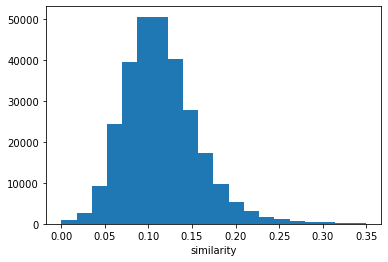

In [9]:
hist(simhist,bins=20);
xlabel('similarity');

Now let's assign points to clusters. As mentioned above, we do that by defining the picked compounds to be the centroids and then assign each other compound in the dataset to the nearest cluster centroid.

We don't currently have a single call for doing this, so here's a Python function:

In [10]:
from collections import defaultdict
import numpy as np
def assignPointsToClusters(picks,fps):
    clusters = defaultdict(list)
    for i,idx in enumerate(picks):
        clusters[i].append(idx)
    sims = np.zeros((len(picks),len(fps)))
    for i in range(len(picks)):
        pick = picks[i]
        sims[i,:] = DataStructs.BulkTanimotoSimilarity(fps[pick],fps)
        sims[i,i] = 0
    best = np.argmax(sims,axis=0)
    for i,idx in enumerate(best):
        if i not in picks:
            clusters[idx].append(i)
    return clusters

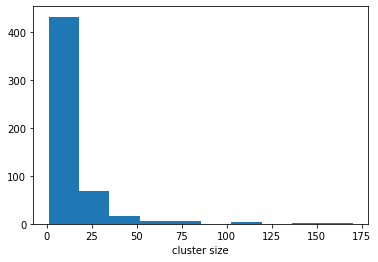

In [11]:
clusters = assignPointsToClusters(picks,fps)
hist([len(clusters[x]) for x in clusters]);
xlabel('cluster size');

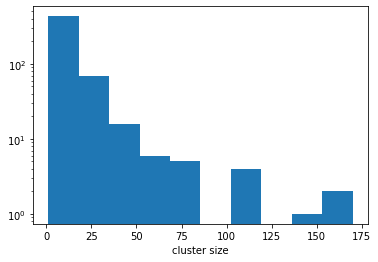

In [12]:
hist([len(clusters[x]) for x in clusters],log=True);
xlabel('cluster size');

Unfortunately this implementation for assigning compounds to clusters isn't particularly efficient since it makes a bunch of calls across the Python/C++ interface:

In [13]:
%timeit assignPointsToClusters(picks,fps)

360 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


I hope to have the chance to improve the performance of this step in a future RDKit release.

## Looking at the clusters

Let's look at the compounds inside a couple of clusters in order to see how closely related they seem to be:

In [14]:
clusts12 = [x for x in clusters if len(clusters[x])==12]
len(clusts12)

10

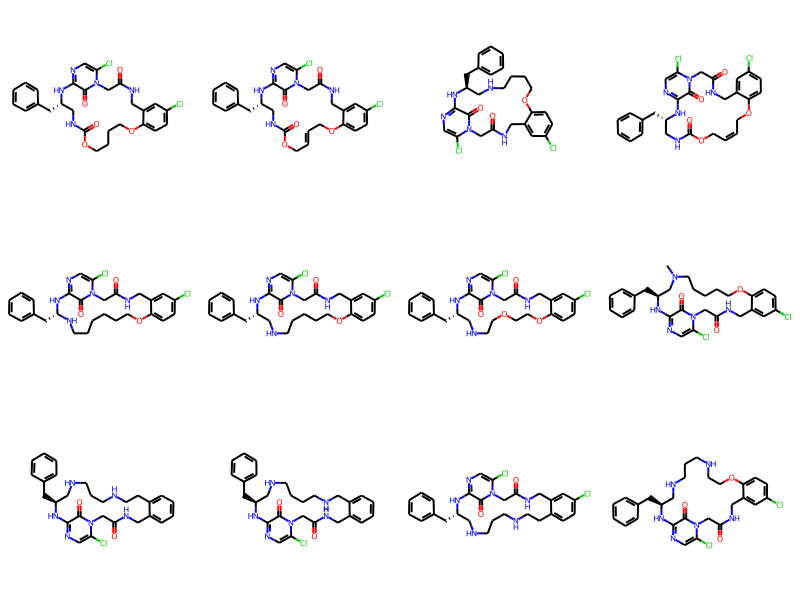

In [15]:
Draw.MolsToGridImage([ms[x] for x in clusters[clusts12[0]]],molsPerRow=4)

We can also look at the intra-cluster similarities

In [16]:
def intracluster_similarities(cluster,fps):
    res = []
    cfps = [fps[x] for x in cluster]
    for i,fpid in enumerate(cluster):
        tres = DataStructs.BulkTanimotoSimilarity(cfps[i],cfps)
        del tres[i]
        res.extend(tres)
    return res
        

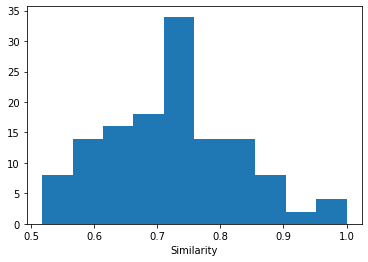

In [17]:
hist(intracluster_similarities(clusters[clusts12[0]],fps));
xlabel('Similarity');

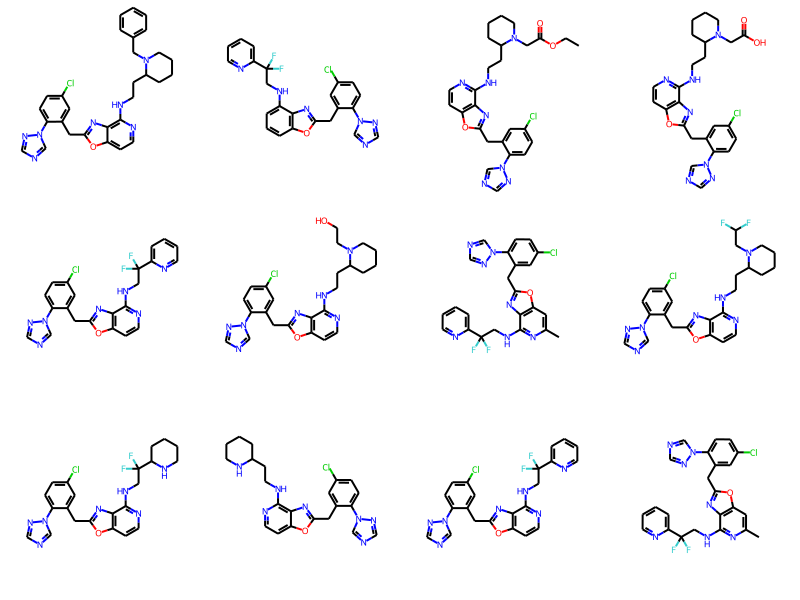

In [18]:
Draw.MolsToGridImage([ms[x] for x in clusters[clusts12[1]]],molsPerRow=4)

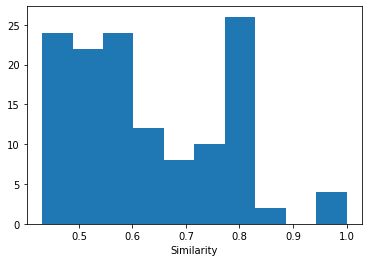

In [19]:
hist(intracluster_similarities(clusters[clusts12[1]],fps));
xlabel('Similarity');

Both clusters are clearly include related compounds

## Decreasing the sphere radius

What about if we make the clusters tighter by decreasing the threshold distance?

In [20]:
thresh = 0.35 # <- minimum distance between cluster centroids
picks = lp.LazyBitVectorPick(fps,len(fps),thresh)
print(len(picks))

1832


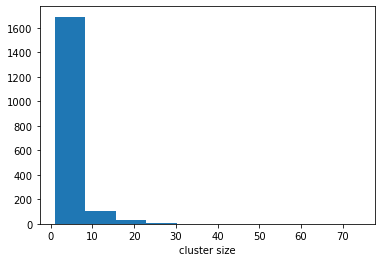

In [21]:
clusters = assignPointsToClusters(picks,fps)
hist([len(clusters[x]) for x in clusters]);
xlabel('cluster size');

We've got more clusters and they are smaller. No big surprise

And let's look at a couple of those

In [22]:
clusts12 = [x for x in clusters if len(clusters[x])==12]
len(clusts12)

17

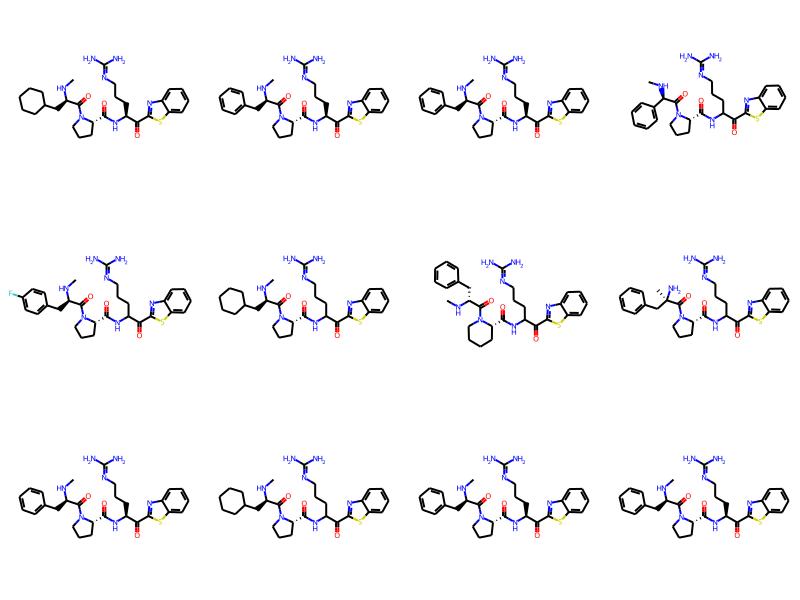

In [23]:
Draw.MolsToGridImage([ms[x] for x in clusters[clusts12[0]]],molsPerRow=4)

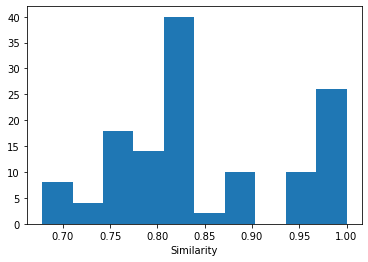

In [24]:
hist(intracluster_similarities(clusters[clusts12[0]],fps));
xlabel('Similarity');

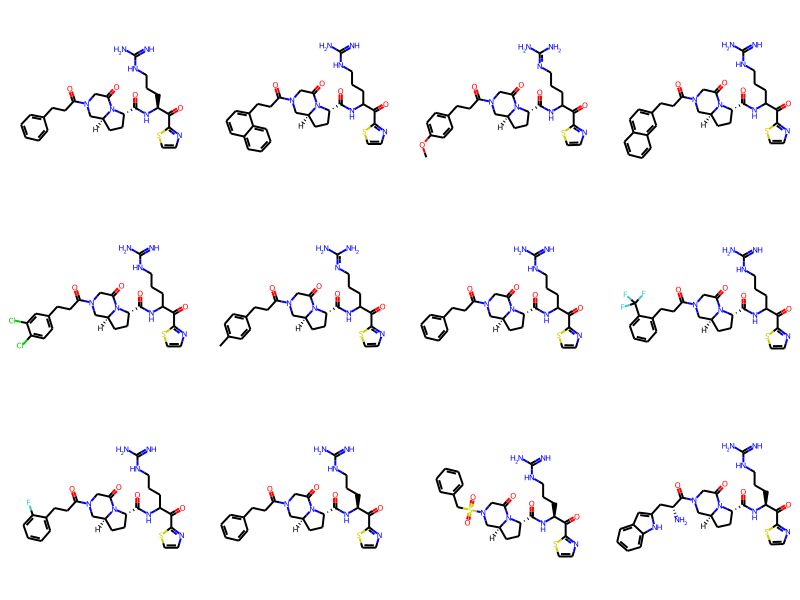

In [25]:
Draw.MolsToGridImage([ms[x] for x in clusters[clusts12[1]]],molsPerRow=4)

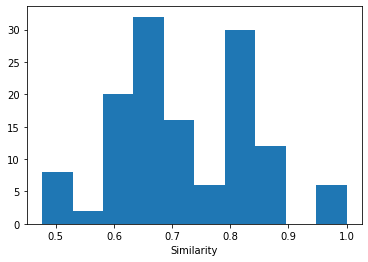

In [26]:
hist(intracluster_similarities(clusters[clusts12[1]],fps));
xlabel('Similarity');

Again, those mostly look quite similar to each other, maybe even more similar than before?

## Impact of sphere radius on the number of clusters

Look at the number of clusters as a function of the threshold

In [27]:
results = []
for thresh in arange(0.65,0.05,-0.05):
    tpicks = lp.LazyBitVectorPick(fps,len(fps),thresh)
    results.append([thresh,len(tpicks)])

Text(0.5, 0, 'distance threshold')

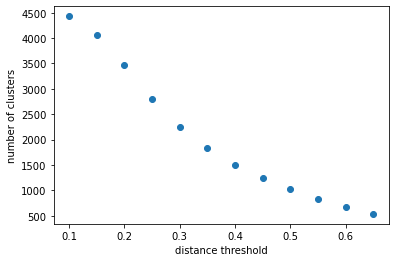

In [28]:
scatter([x for x,y in results],[y for x,y in results]);
ylabel('number of clusters')
xlabel('distance threshold')

# Trying a larger dataset

I said that Roger's implementation was efficient, but the dataset above wasn't all that big. Let's try a larger one.

Here we'll use the full set of compounds I grabbed data for when building the [new "Lessel and Briem" datasets](http://rdkit.blogspot.com/2019/10/a-new-lessel-and-briem-like-dataset.html).

As an aside, this is also a nice opportunity to demonstrate using the `MultithreadedSmilesMolSupplier` that Shrey Aryan added to the RDKit as part of his [2020 Google Summer of Code project](https://github.com/rdkit/rdkit/pull/3363). This new supplier allows molecules to be constructed in parallel and can, in some situations, really speed things up.

In [29]:
t1 = time.time()
fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m,2,2048) for m in \
       Chem.MultithreadedSmilesMolSupplier('../data/BLSets_actives.txt',numWriterThreads=4,delimiter='\t') if m is not None]
t2 = time.time()
print(f"That took {t2-t1 :.2f} seconds to build {len(fps)} fingerprints")

That took 6.02 seconds to build 91663 fingerprints


Running that single threaded (i.e. using a normal `SmilesMolSupplier`) took 16.8 seconds on my machine.

Pick the cluster centroids:

In [30]:
lp = rdSimDivPickers.LeaderPicker()
thresh = 0.65 # <- minimum distance between cluster centroids
picks = lp.LazyBitVectorPick(fps,len(fps),thresh)
print(len(picks))

2997


How long does that take?

In [32]:
%timeit lp.LazyBitVectorPick(fps,len(fps),thresh)

5.14 s ± 320 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That took 43.34 seconds


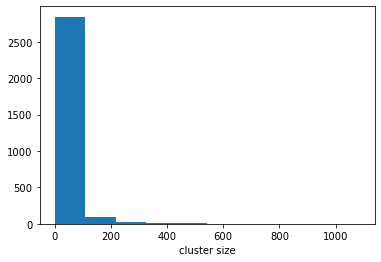

In [33]:
t1 = time.time()
clusters = assignPointsToClusters(picks,fps)
t2=time.time()
print(f"That took {t2-t1 :.2f} seconds")
hist([len(clusters[x]) for x in clusters]);
xlabel('cluster size');

And, finally, look at the number of clusters and clustering time as a function of the sphere radius

In [34]:
results = []
for thresh in (0.2,0.3,0.4,0.5,0.6,0.7,0.8):
    lp = rdSimDivPickers.LeaderPicker()
    t1 = time.time()
    picks = lp.LazyBitVectorPick(fps,len(fps),thresh)
    t2 = time.time()
    print(f"distance threshold {thresh: .2f}, {len(picks)} clusters in {t2-t1 :.2f} seconds")
    results.append((thresh,len(picks),t2-t1))

distance threshold  0.20, 34535 clusters in 66.25 seconds
distance threshold  0.30, 20627 clusters in 37.51 seconds
distance threshold  0.40, 11799 clusters in 21.47 seconds
distance threshold  0.50, 6811 clusters in 12.48 seconds
distance threshold  0.60, 4047 clusters in 7.02 seconds
distance threshold  0.70, 2021 clusters in 3.07 seconds
distance threshold  0.80, 558 clusters in 0.51 seconds


Those two track nicely with each other; more clusters = longer run time:

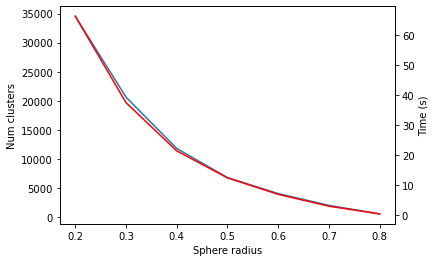

In [35]:
fig, ax = subplots()
ax.plot([x[0] for x in results],[x[1] for x in results]);
ax.set_xlabel('Sphere radius');
ax.set_ylabel('Num clusters');
ax2 = ax.twinx()
ax2.plot([x[0] for x in results],[x[2] for x in results],c='r');
ax2.set_ylabel('Time (s)');